In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Chap 12. Time analysis
- 시간 순서대로 정렬된 데이터에서 의미 있는 요약과 통계 정보 추출 + 미래 행동 예측
- 시계열 데이터는 시간 흐름에 따라 서로 연결된 형태여야 하고 되도록 규칙적인 간격으로 수집해야 한다.
- 종류
    - 일변량 : 시간에 대해 측정된 변수가 하나만 있는 경우
    - 다변량 : 각 타임스탬프에서 측정된 변수가 여러개 인 경우

In [5]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv").filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts.set_index('날짜')
ts_head = ts.head(334)
ts_tail = ts.tail(31)
print(ts_head)                                                                                                            

            전일대비증감수
날짜                 
2021-01-01      357
2021-01-02      250
2021-01-03      198
2021-01-04      329
2021-01-05      199
...             ...
2021-11-26     1742
2021-11-27     1888
2021-11-28     1676
2021-11-29     1393
2021-11-30     1186

[334 rows x 1 columns]


## 12-1 시계열 탐색적 분석
### 12-1-1 일반적 EDA
- 실제 측정치보다, 한 측정치가 다음 측정치로 변화한 정도가 중요 => 차분하여 추세가 제거된 데이터를 히스토그램 및 산점도

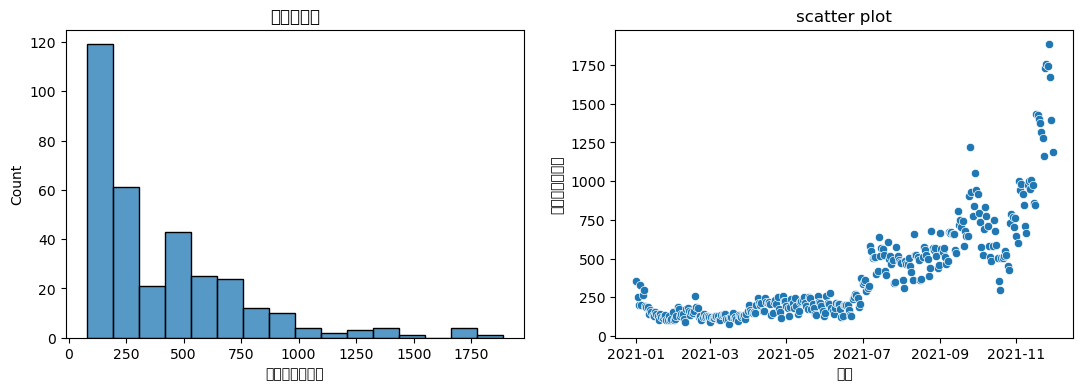

           전일대비증감수
count   334.000000
mean    405.152695
std     336.013188
min      79.000000
25%     152.000000
50%     252.500000
75%     556.000000
max    1888.000000


In [7]:
# 차분 없는 시계열
fig, axes = plt.subplots(1,2, figsize=(13,4))
axes[0].set_title("히스토그램")
sns.histplot(x='전일대비증감수', data=ts_head, ax=axes[0])

axes[1].set_title("scatter plot")
sns.scatterplot(x='날짜', y='전일대비증감수', data=ts_head, ax=axes[1])
plt.show()

print(ts_head.describe())

### 12-1-2 시계열에 특화된 EDA
### 정상성 확인
- 전통적인 시계열 모델은 정상 시계열 데이터를 전제 => 시간이 지나더라도 평균과 분산이 일정하고 추세나 계절성을가지지 않음
- 확인 방법
    - ADF (Augmented Dickey-Fuller) 검정 : "단위근(unit root)가 있다"를 귀무가설로, 단위근(unit root)가 없다"를 대립가설로 설정하고 검정. 대립가설을 채택하여 단위근이 없는 시계열이 정상시계열
    - KPSS (Kwiatowski-Philips-Schmidt-Shin) 검정 : '정상 시계열'을 귀무가설로, '비정상 시계열'을 대립가설로 설정하고 검정. 귀무가설을 기각하지 않을 경우 정상시계열
    - ACF 그래프 : 시차(time lag)가 증가할수록 0으로 빨리 떨어진다

[정상화 방법]
- 평균이 일정하지 않는 경우 : 차분
- 분산이 일정하지 않는 경우 : 변환 => 로그 변환, 제곱근 변환, Box-cox, Yeo-Johnson

ADF Statistics: 0.762, p-value 0.991
KPSS Statistics: 2.210, p-value 0.010


/Users/klee30810/miniconda3/envs/adp_class/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


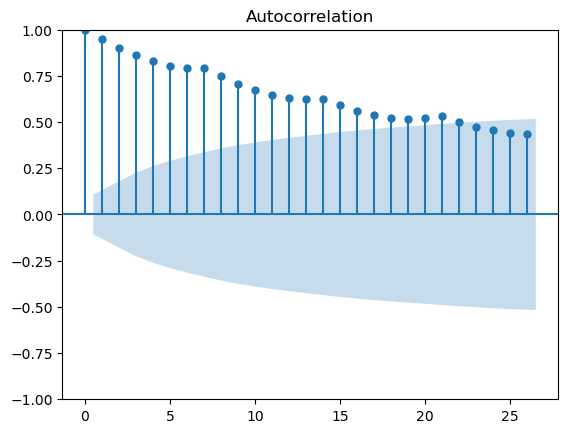

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

# ADF
# H0 : 단위근 포함(비정상), # H1 : 단위근 포함하지 않음 (정상)
result = adfuller(ts_head, regression='c', autolag='AIC')
print(f"ADF Statistics: {result[0]:.3f}, p-value {result[1]:.3f}")

# KPSS
# H0 : 정상 시계열과 차이가 없다(정상), # H1 : 정상 시계열과 차이가 있다(비정상)
result = kpss(ts_head, regression='c', nlags='auto')
print(f"KPSS Statistics: {result[0]:.3f}, p-value {result[1]:.3f}")

# ACF-graph
plot_acf(ts_head)
plt.show()

### 자기상관 확인
- 서로 다른 시점의 데이터 간의 상관관계
    - ACF(Autocorrelation function) : lag에 따른 관측치들 사이의 관련성 측정
        - y축에 자기상관계수를 놓고 임계영역에서 벗어나면 자기상관
    - PACF(Partial autocorrelation function) : k이외의 모든 다른 시점 관측치의 영향력을 배제하고 $y_l$, $y_{t-k}$의 관련성 측정
        - 어느 시차의 데이터와 자기상관 가지는지 확인
    - Ljung-box test : H0 '자기상관이 없다', H1 '자기상관이 있다'
    - Durbin-watson test : 통계량이 2에 가까울 수록 자기상관이 없고 0이 가까울수록 양의 상관관계, 4에 가까울수록 음의 상관관계

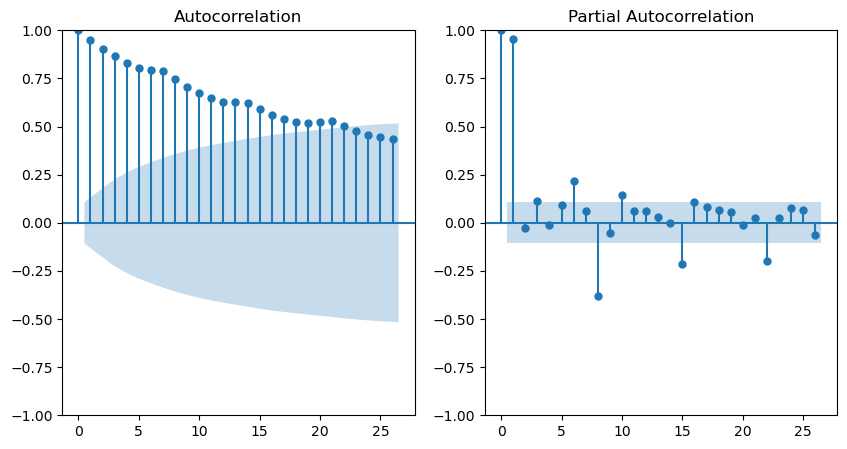


ACF 그래프 임계영역 벗어나는 값 존재 & PACF 그래프 임계영역 벗어나는 시차 1,3,6,8 자기상관

0 시차: 자기상관계수 1.000, 신뢰구간 1.000 ~ 1.000
1 시차: 자기상관계수 0.954, 신뢰구간 0.846 ~ 1.061
2 시차: 자기상관계수 0.907, 신뢰구간 0.727 ~ 1.087
3 시차: 자기상관계수 0.873, 신뢰구간 0.646 ~ 1.100

Ljung-box test
      lb_stat      lb_pvalue
1  304.691106   3.131578e-68
2  579.605498  1.381228e-126
3  833.394832  2.474556e-180


[0.03337102]


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

# ACF/PACF
fig, axes = plt.subplots(1,2, figsize=(10,5))
plot_acf(ts_head, ax=axes[0])
plot_pacf(ts_head, ax=axes[1])
plt.show()
print(
"""
ACF 그래프 임계영역 벗어나는 값 존재 & PACF 그래프 임계영역 벗어나는 시차 1,3,6,8 자기상관
""")

ACs, confs = acf(ts_head, fft=False, nlags=3, alpha=0.05, adjusted=True)
for lag, ac, conf in zip(range(3+1), ACs, confs):
    print(f"{lag} 시차: 자기상관계수 {ac:.3f}, 신뢰구간 {conf[0]:.3f} ~ {conf[1]:.3f}")
    
# Ljung-box test
# H0 : 데이터가 일련의 상관관계가 없다 / H1 : 데이터가 일련의 상관관계를 나타낸다
print("\nLjung-box test")
result = acorr_ljungbox(ts_head, return_df=True, auto_lag=True).head(3)
print(result)

# Durbin-watson test
# 2 : 자기 상관이 없다, 4 or 0: 자기 산관이 있다
result = durbin_watson(ts_head)
print("\n")
print(result)

### 시계열 분해
- 시계열 데이터를 추세(trend), 계절성(season), 순환(=주기, cycle), 불규칙 변동(irregular variation)으로 분해
- 이동평균 : 일정 기간 별 이동평균을 계산함으로써 계절 변동과 불규칙 변동을 제거하고 추세 변동과 순환 변동만 가진 시계열로 분해
- 지수평활법 : 모든 시계열 자료를 사용해 평균을 구하며, 시간에 흐름에 따라 최근 시계열에 더 많은 가중치를 부여하여 불규칙 변동 제거
- STL(Seasonal & Trend decomposition using loss) : 계절 변동, 추세 변동, 잔차로 분해하여 각각 살펴볼 수 있다

Moving average


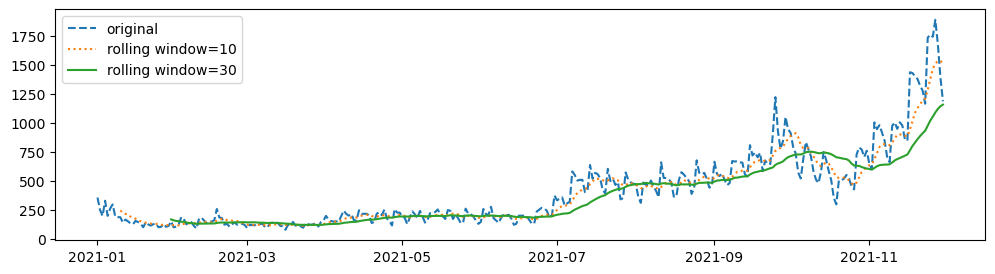

Exponential weight


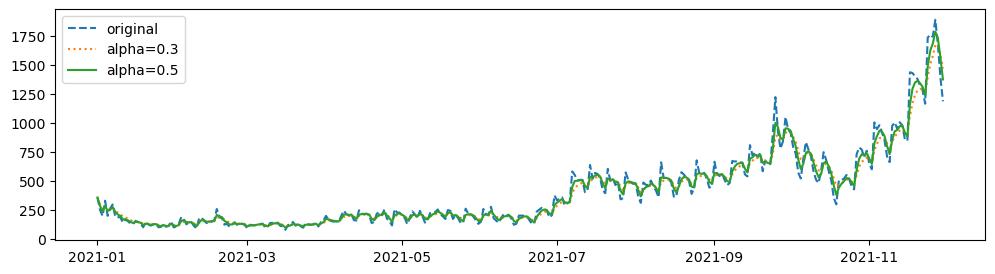

STL Decomposition


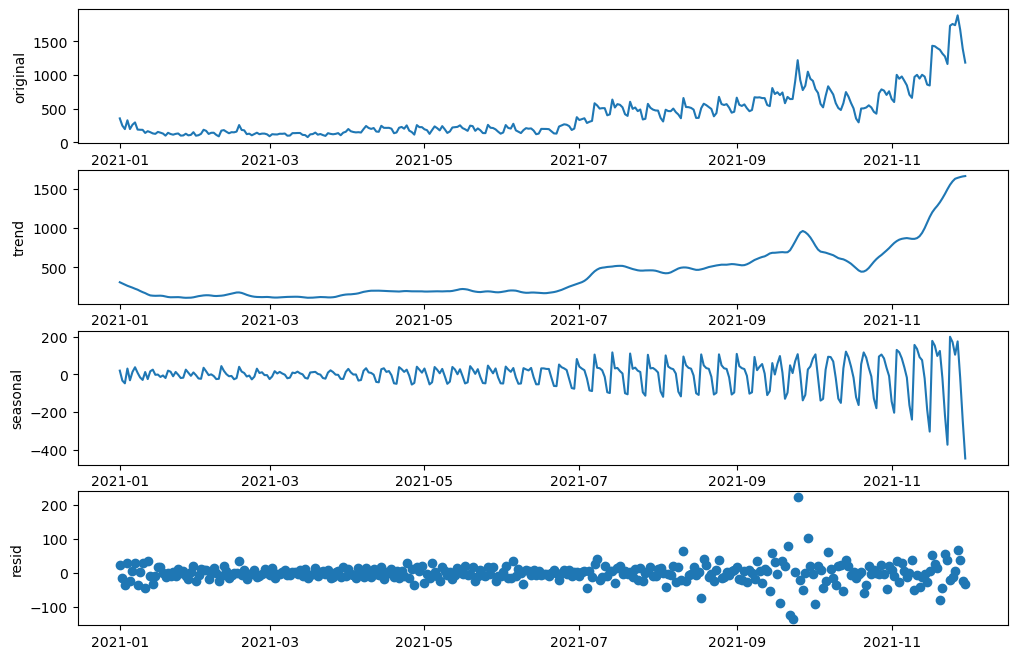

In [15]:
from statsmodels.tsa.seasonal import STL

# 이동평균
print("Moving average")
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles = ['original', 'rolling window=10', 'rolling window=30']
rw10 = ts_head.rolling(window=10).mean().dropna()
rw30 = ts_head.rolling(window=30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

# 지수평활법 : 불규칙 변동 제거
print("Exponential weight")
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles = ['original', 'alpha=0.3', 'alpha=0.5']
ewm03 = ts_head.ewm(alpha=0.3).mean()
ewm05 = ts_head.ewm(alpha=0.5).mean()
data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

# STL 분해
# seasonal = length of the seasonal smoother
# trend = length of the trend smoother
print("STL Decomposition")
fitted = STL(ts_head, seasonal=7, trend=9).fit()
resid = fitted.resid
seasonal = fitted.seasonal
trend = fitted.trend

titles = ['original', 'trend', 'seasonal', 'resid']
data_list = [ts_head, trend, seasonal, resid]
fig, axes = plt.subplots(4, 1, figsize=(12,8))
for title, data, ax in zip(titles, data_list, axes):
    ax.set_ylabel(title)
    if title != 'resid':
        ax.plot(data)
    else:
        ax.scatter(x=data.index, y=data.values)

plt.show()

## 12-2 시계열 데이터 전처리
### 시계열 데이터 다루기
- 날짜를 datetime 타입으로 되어야 함

In [23]:
# 날짜 데이터로 타입 변경하기

import datetime
import time
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv")

# object -> datetime
print("object: ", ts['날짜'].dtype)
ts['날짜'] = ts['날짜'].astype('datetime64')
print("object to datetime: ", ts['날짜'].dtypes)

# string -> datetime
string = "2018-09-13 22:39:04"
print("string: ", type(string))
datetime = datetime.datetime.strptime(string, "%Y-%m-%d %H:%M:%S")
print("string to datetime: ", type(datetime))
string2 = datetime.strftime("%Y-%m-%d %H:%M:%S")
print("datetime to string: ", type(string2))

# timestamp -> datetime
timestamp = 2551700740
datetime = datetime.fromtimestamp(timestamp)
timestamp2 = time.mktime(datetime.timetuple())
print("timestamp: ", timestamp)
print("timestamp to datetime: ", datetime)
print("datetime to timestamp: ", timestamp2)

object:  object
object to datetime:  datetime64[ns]
string:  <class 'str'>
string to datetime:  <class 'datetime.datetime'>
datetime to string:  <class 'str'>
timestamp:  2551700740
timestamp to datetime:  2050-11-10 22:45:40
datetime to timestamp:  2551700740.0


In [31]:
import datetime

# 날짜 데이터 생성하기
date1 = dt.datetime(2023, 3, 20, 16, 0, 0)
# year, month, day, hour, minute, second
date2 = dt.datetime.now()
date_only = datetime.date(2019,1,1)
time_only = datetime.time(10, 0, 5)
print("직접 지정한 날씨 : ", date1)
print("현재 시간을 반환하는 날짜 데이터 : ", date2)
print("date_only: ", date_only)
print("time_only: ", time_only)

## 시작날짜, 종료날짜, 날짜 개수(periods), 날짜의 간격 단위(freq)
## freq = ['A(년)', 'M(월)', 'D(일)', 'T(분)', 'S(초)', 'Q(분기)', 'W(주)']
date_list1 = pd.date_range('2016-01-01', periods=3, freq='D')
date_list2 = pd.date_range('2016-01-01', periods=4, freq='W')
date_list3 = pd.date_range('2016-01-01', '2016-01-02', freq='30T')
print("일 단위 날짜들 3개: \n", date_list1, '\n')
print("주 단위 날짜들 3개: \n", date_list2, '\n')
print("시작-종료 날짜들 사이 30분 단위 날짜들: \n", date_list3[:2])

date_list4 = pd.period_range('2012-01-01', freq='A', periods=2)
date_list5 = pd.period_range('2012-01-01', freq='Q', periods=3)
print("년 단위 날짜들 2개: \n", date_list4, '\n')
print("분기 단위 날짜들 3개: \n", date_list5, '\n')

직접 지정한 날씨 :  2023-03-20 16:00:00
현재 시간을 반환하는 날짜 데이터 :  2024-07-09 00:00:18.513861
date_only:  2019-01-01
time_only:  10:00:05
일 단위 날짜들 3개: 
 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D') 

주 단위 날짜들 3개: 
 DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24'], dtype='datetime64[ns]', freq='W-SUN') 

시작-종료 날짜들 사이 30분 단위 날짜들: 
 DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00'], dtype='datetime64[ns]', freq='30T')
년 단위 날짜들 2개: 
 PeriodIndex(['2012', '2013'], dtype='period[A-DEC]') 

분기 단위 날짜들 3개: 
 PeriodIndex(['2012Q1', '2012Q2', '2012Q3'], dtype='period[Q-DEC]') 



In [33]:
# 날짜 데이터의 형태, 값 변경하기
date3 = dt.datetime(2023, 3, 20, 0, 1, 10)
date3_c1 = date3.strftime("%Y-%m-%d")
date3_c2 = date3.strftime("%y년 %ㅡ-%ㅇ %ㅗ:%ㅡ")
print("형태 변경 전: ", date3)
print("형태 변경 후 1: ", date3_c1)
print("형태 변경 후 2: ", date3_c2)

date4 = date3.replace(year=2022, minute=2)

print("값 변경 전: ", date3)
print("값 변경 후: ", date4)

date_only = dt.date(2019,1,1)
time_only = dt.time(10,0,5)
datetime = dt.datetime.combine(date_only, time_only)
print("값 병합 전: ", date_only, time_only)
print("값 병합 후: ", datetime)

형태 변경 전:  2023-03-20 00:01:10
형태 변경 후 1:  2023-03-20
형태 변경 후 2:  23년 ㅡ-ㅇ ㅗ:ㅡ
값 변경 전:  2023-03-20 00:01:10
값 변경 후:  2022-03-20 00:02:10
값 병합 전:  2019-01-01 10:00:05
값 병합 후:  2019-01-01 10:00:05


In [34]:
# 날짜 데이터 간 연산
weeks1 = dt.timedelta(weeks=1)
today = dt.date(2023,2,10)
print("오늘: ", today)
print("오늘로부터 1주 전: ", today - weeks1)
print("오늘로부터 1주 후: ", today + weeks1)

오늘:  2023-02-10
오늘로부터 1주 전:  2023-02-03
오늘로부터 1주 후:  2023-02-17


In [35]:
# 날짜 추출
print("\n 년, 월, 일, 요일명, 요일인덱스, 추출하기: \n")
ts['날짜'] = ts['날짜'].astype('datetime64')
ts['년'] = ts['날짜'].dt.year
ts['월'] = ts['날짜'].dt.month
ts['일'] = ts['날짜'].dt.day
ts['요일1'] = ts['날짜'].dt.weekday
ts['요일2'] = ts['날짜'].dt.day_name()
print(ts.filter(['날짜', '년', '월', '일', '요일1', '요일2']).head())


 년, 월, 일, 요일명, 요일인덱스, 추출하기: 

          날짜     년  월  일  요일1       요일2
0 2021-01-01  2021  1  1    4    Friday
1 2021-01-02  2021  1  2    5  Saturday
2 2021-01-03  2021  1  3    6    Sunday
3 2021-01-04  2021  1  4    0    Monday
4 2021-01-05  2021  1  5    1   Tuesday


### 시계열 빈도 변경 (업샘플링, 다운샘플링)
- 업샘플링 : 불규칙적으로 샘플링 된 시계열 데이터를 규칙적인 형태로 변환하거나 현재 샘플링된 것보다 더 높은 빈도로 변환할 필요 있을 때
- 다운샘플링 : 원본 데이터의 시간 단위가 너무 작아서 실용적이지 않거나, 현재 샘플링 된 것보다 더 낮은 빈도로 변환할 필요 있을 때

In [39]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv")
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts.set_index('날짜')
# rule = 'A(년)', 'M(월)', 'D(일)', 'T(분)', 'S(초)', 'Q(분기)', 'W(주)'
print("\n[freq='Q', asfreq]") # 해당 기간 대표 날짜의 데이터 변환
print(ts.resample(rule='Q').asfreq())

print("\n[freq='Q', sum]") # 해당 기간의 데이터 합을 변환
print(ts.resample(rule='Q').sum())

print("\n[freq='Q', mean]") # 해당 기간의 데이터 평균을 변환
print(ts.resample(rule='Q').mean())


[freq='Q', asfreq]
            누적확진자수  전일대비증감수
날짜                         
2021-03-31   32029      158
2021-06-30   49986      375
2021-09-30  100492      945
2021-12-31  225235     1670

[freq='Q', sum]
              누적확진자수  전일대비증감수
날짜                           
2021-03-31   2357075    13034
2021-06-30   3726692    17957
2021-09-30   6672971    50508
2021-12-31  13440595   124799

[freq='Q', mean]
                   누적확진자수      전일대비증감수
날짜                                    
2021-03-31   26189.722222   144.822222
2021-06-30   40952.659341   197.329670
2021-09-30   72532.293478   549.000000
2021-12-31  146093.423913  1356.510870


### 결측치 처리
- forward fill : 누락단 값이 나타나기 직전의 값으로 누락된 값 채움
- backward fill : 누락단 값이 나타나기 직후의 값으로 누락된 값 채움
    - 사전관찰이기 때문에, 데이터를 사용하여 미래를 예측하지 않고나, 특정 분야의 지식에 기반하여 데이터의 미래보다 과거를 채우는게 더 의미가 있는 경우에만 사용
- 이동평균 : forward fill과 유사하나 과거의 여러 시간대를 입력한 내용을 사용
- 보간법 : 인접한 데이터를 사용하여 누락한 데이터 추정

결측치 확인:  누적확진자수     0
전일대비증감수    0
dtype: int64
결측치 확인:  누적확진자수     47
전일대비증감수    47
dtype: int64


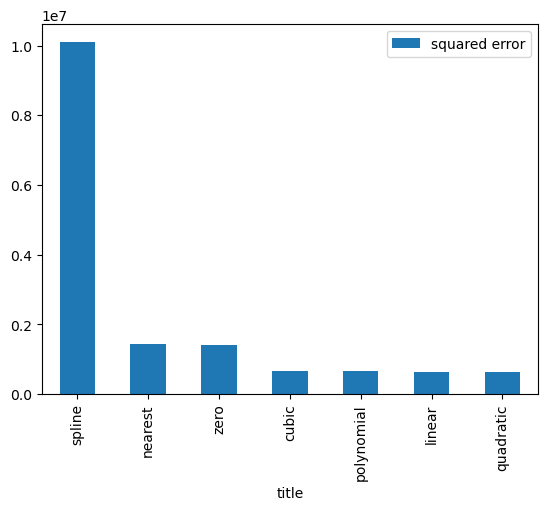

In [47]:
import numpy as np

ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv")
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts.set_index('날짜')
print("결측치 확인: ", ts.isna().sum())

ts_na = ts.copy()
random_numbers = np.random.randint(0, len(ts)-1, 50)
for num in random_numbers:
    ts_na.iloc[num, :] = np.nan
print("결측치 확인: ", ts_na.isna().sum())

linear = ts_na.interpolate(method='linear')
nearest = ts_na.interpolate(method='nearest')
zero = ts_na.interpolate(method='zero')
quadratic = ts_na.interpolate(method='quadratic') 
cubic = ts_na.interpolate(method='cubic') 
spline = ts_na.interpolate(method='spline', order=2) 
polynomial = ts_na.interpolate(method='polynomial', order=3) 

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic', 'spline', 'polynomial']
data_list = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_error = []
for title, data in zip(titles, data_list):
    sqrd_e = sum((ts-data)['전일대비증감수']**2)
    sqrd_error.append(int(sqrd_e))
result = pd.DataFrame({'title':titles, 'error':sqrd_error}).sort_values(by='error', ascending=False)
result.plot.bar(x='title', y='error', label='squared error')
plt.show()

### 차분과 변환
- EDA 단계에서 시계열 데이터가 정상성을 가지지 않는 것으로 확인도니 경우, 차분과 변환을 통한 데이터 전처리 필요

original : ADF p-value 0.991, KPSS p-value 0.010
diff(1) : ADF p-value 0.004, KPSS p-value 0.100
diff(2) : ADF p-value 0.005, KPSS p-value 0.100


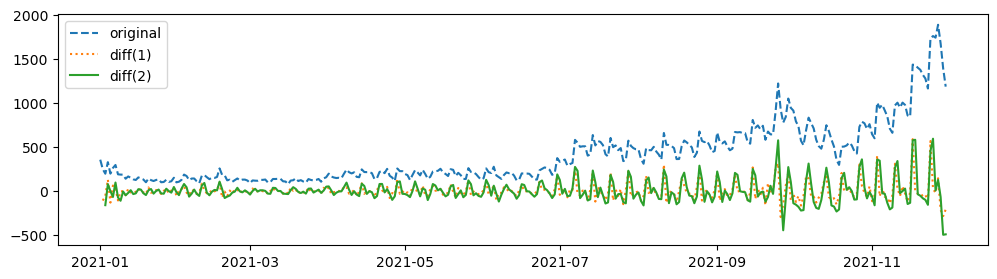

In [67]:
from statsmodels.tsa.stattools import adfuller, kpss

ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv").filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts.set_index('날짜')
ts_head = ts.head(334)
ts_tail = ts.tail(31)

fig, ax = plt.subplots(1,1, figsize=(12,3))
titles = ['original', 'diff(1)', 'diff(2)']
diff1 = ts_head.diff(periods=1).dropna()
diff2 = ts_head.diff(periods=2).dropna()
data_list = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print(f"{title} : ADF p-value {ap:.3f}, KPSS p-value {kp:.3f}")

plt.legend()
plt.show()

original : ADF p-value 0.991, KPSS p-value 0.010
log : ADF p-value 0.001, KPSS p-value 0.100
box-cox : ADF p-value 0.000, KPSS p-value 0.100


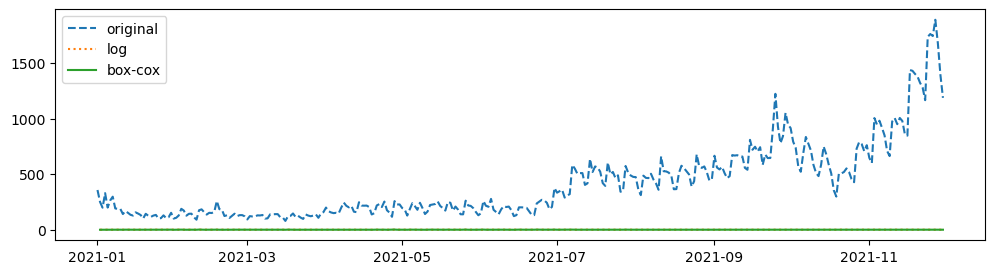

In [68]:
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer

log = np.log(ts_head)
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# diff(1)
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

titles = ['original', 'log', 'box-cox']
data_list = [ts_head, log, boxcox]
ls_list = ['dashed', 'dotted', 'solid']
fig, ax = plt.subplots(1,1,figsize=(12,3))
for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print(f"{title} : ADF p-value {ap:.3f}, KPSS p-value {kp:.3f}")

plt.legend()
plt.show()

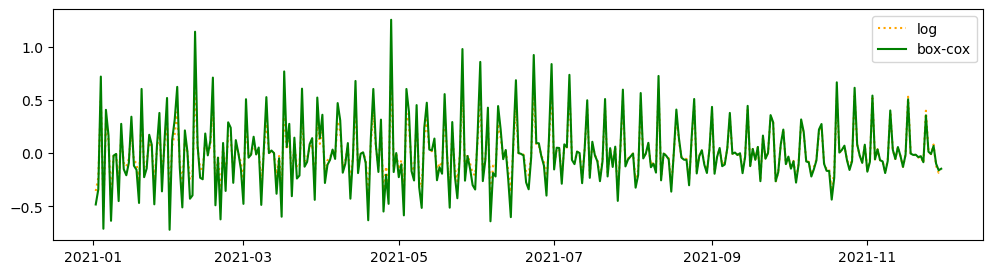

In [69]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
titles, data_list = ['log', 'box-cox'], [log, boxcox]
ls_list, c_list = ['dotted', 'solid'], ['orange', 'green']
for title, data, ls, c in zip(titles, data_list, ls_list, c_list):
    ax.plot(data, label=title, linestyle=ls, color=c)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    
plt.legend()
plt.show()

## 12-3 시계열 모델링 및 평가
- 시계열 모델의 평가는 회귀모델의 평가지표와 동일
- ARIMA(Auto-regressive integrated moving aveerage) : 자기회귀 + 이동평균
- 계절성 ARIMA : 승법 계절성 가정 = ARIMA(p,d,q) * (P,D,Q)m
    - 계절 주기 당 시간 단계의 수를 정하는 m을 가진 ARIMA과정
    - 시간 상 인접한 데이터가 동일한 계절 또는 서로 다른 계절에 있어도 시간적으로 근접한 일반적인 방법으로 인식
    
### Box-Jenkins 방법과 ARIMA
- 정상성 및 계절성 : 시계열의 정상성 여부와 모델링해야 할 중요한 계절성 있는지 확인
- 정상성을 위한 작업 : 차분과 변환
- 적절한 차수 p와 q 찾기 : ACF/PACF 그래프를 통해 자기회귀(AR) 및 이동평균(MA) 항의 차수 p, q를 찾는다. 
    - AR(p)는 ACF값이 천천히 감소하고 PACF 값은 p 이후에 빠르게 감소한다
    - MA(q)는 ACF값이 q이후에 빠르게 감소하고 PACF에서 천천히 감소한다.
    - ARIMA는 둘다 가파른 절단이 없다
- 앞선 p,q는 비계절성에 대한 차수이고, P,Q,m이라는 계절성 차수도 고려
    - ACF 그래프의 시차 m에서 뾰족한 막대는 있지만 다른 유의미한 뾰족한 막대가 없음
    - PACF 그래프의 계절성 시차가 지수족으로 감소하면 Q=1로 둘 수 있다.
    - ACF그래프의 계절성 시차가 지수적으로 감소하고, PACF시차 m에서 뾰족한 막대는 있지만 다른 유의미한 뾰족한 막대가 없는 경우 P=1로 둘 수 있다.
- 예측한 모델이 잔차가 자기상관이 없고, 정상성을 갖는다면, 해당 모델을 최종 ARIMA 모델로 선택

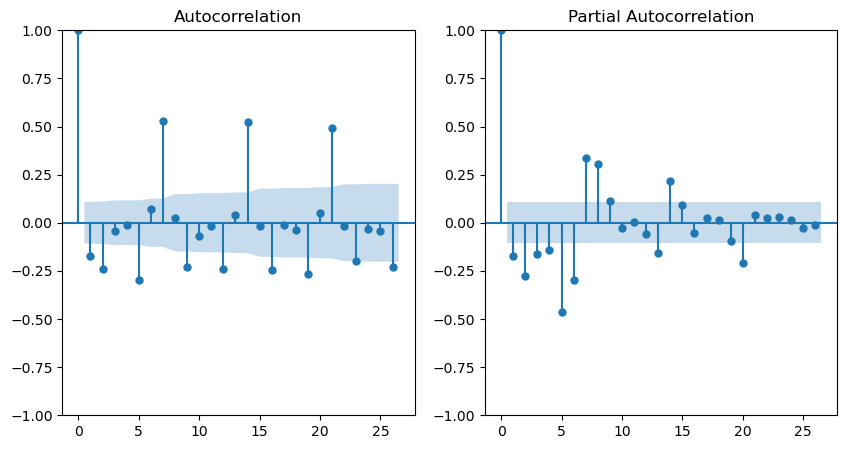

In [72]:
# boxcox 변환 및 차분을 통해 정상화한 시계열 데이터 'boxcox'로 적절한 차수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(boxcox, ax=ax[0])
plot_pacf(boxcox, ax=ax[1])
plt.show()
# p=9, q=2 선택

# 모델의 비계절성
p = 9; d = 1; q = 2

# 모델의 계절성 (계절성이 없으면 생략 가능)
P = 0; D = 0
Q = 1 # ACF lag7에서 뾰족한 막대를 가지고, PACF는 지수적으로 감소
s = 7 # ACF lag7에서 뾰족한 막대를 가짐, 계절성 단위

In [73]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = ARIMA(ts_head, order=(p,d,q), seasonal_order=(P, D, Q, s))
fitted = model.fit()
resid = fitted.resid

# pred1,2는 동일
pred1 = fitted.forecast(31)
pred2 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

fitted.summary()
# 잔차의 정규성 확인 : Jarque-Bera의 귀무가설 채택하면 정규성 => 불만족
# 잔차의 자기상관 확인 : Ljung-Box 의 귀무가설 채택하면 자기상관 없음 => 만족

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.018
Date:                           Tue, 09 Jul 2024   AIC                           3734.037
Time:                                   07:48:42   BIC                           3783.542
Sample:                               01-01-2021   HQIC                          3753.777
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0279      1.000     -0.028      0.978      -1.987       1.932
ar.L2         -0.1716      0.495     -0.346      0.729      -1.143       0.799
ar.L3         -0.0261      0.029     -0.914      0.361      -0.082       0.030
ar.L4         -0.0401      0.038     -1.067      0.286      -0.114       0.034
ar.L5         -0.0380      0.033     -1.153      0.249      -0.103       0.027
ar.L6         -0.0319      0.031     -1.023      0.306      -0.093       0.029
ar.L7          0.9457      0.040     23.485      0.000       0.867       1.025
ar.L8          0.0042      0.972      0.004      0.997      -1.902       1.910
ar.L9          0.1370      0.475      0.288      0.773      -0.794       1.068
ma.L1         -0.2071      0.993     -0.209      0.835      -2.154       1.739
ma.L2          0.0486      0.705      0.069      0.945      -1.333       1.430
ma.S.L7       -0.6529      0.059    -11.157      0.000      -0.768      -0.538
sigma2      4657.0493    268.202     17.364      0.000    4131.383    5182.715
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1187.29
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 자동 차수 선택 방법과 ARIMA
- 여러 조합의 차수 적용하여 가능도와 AIC값 비교

In [74]:
# pmdarima의 auto_arima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

print(auto_arima(ts_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True))

model = ARIMA(ts_head, order=(3,1,0), seasonal_order=(1,0,1,7))
fitted = model.fit()
resid = fitted.resid
pred3 = fitted.forecast(31)
pred4 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

print(fitted.summary())
# 잔차의 정규성 확인 : Jarque-Bera의 귀무가설 채택하면 정규성 => 불만족
# 잔차의 자기상관 확인 : Ljung-Box 의 귀무가설 채택하면 자기상관 없음 => 만족

 ARIMA(3,1,0)(1,0,1)[7]          
                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Tue, 09 Jul 2024   AIC                           3717.507
Time:                                   07:49:46   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2261      0.036     -6.295      0.000      -0.297      -0.156
ar.L2    

In [64]:
# 반복문 사용
import itertools
p = range(0,4)
d = range(1,2)
q = range(0,3)
Q = D = P = range(0,2)
m = [4,7,12]
combis = list(itertools.product(p,d,q, P,D,Q,m))

dict_model = {}
for i, combi in enumerate(combis):
    try:
        no_seasonal = combi[:3]
        seasonal = combi[3:]
        model = ARIMA(ts_head, order=(no_seasonal), seasonal_order=(seasonal))
        fitted = model.fit()
        dict_model[combi] = [fitted.llf, fitted.aic] # llf는 높을 수록, AIC는 낮을 수록 좋음
    except:
        print("except: ", i, combi)
        continue
        
result = pd.DataFrame.from_dict(dict_model, orient='index', columns = ['llf', 'AIC']).sort_values(by='AIC', ascending=True)
print(result)

                               llf          AIC
(1, 1, 0, 1, 0, 1, 7)     0.000000     8.000000
(3, 1, 1, 0, 1, 1, 7) -1807.948928  3627.897856
(3, 1, 2, 0, 1, 1, 7) -1807.943342  3629.886684
(3, 1, 0, 0, 1, 1, 7) -1810.092109  3630.184218
(0, 1, 2, 0, 1, 1, 7) -1811.281482  3630.562964
...                            ...          ...
(3, 1, 0, 0, 1, 0, 4) -2067.112994  4142.225988
(2, 1, 0, 0, 1, 0, 4) -2086.585068  4179.170136
(0, 1, 1, 0, 1, 0, 4) -2088.194196  4180.388392
(1, 1, 0, 0, 1, 0, 4) -2088.409186  4180.818373
(0, 1, 0, 0, 1, 0, 4) -2089.657718  4181.315436

[288 rows x 2 columns]


In [65]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_head, order=(3,1,1), seasonal_order=(0,1,1,7))
fitted = model.fit()
resid = fitted.resid

pred5 = fitted.forecast(31)
pred6 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

fitted.summary()
# 잔차의 정규성 확인 : Jarque-Bera의 귀무가설 채택하면 정규성 => 불만족
# 잔차의 자기상관 확인 : Ljung-Box 의 귀무가설 채택하면 자기상관 없음 => 만족

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1807.949
Date:                         Tue, 09 Jul 2024   AIC                           3627.898
Time:                                 07:47:54   BIC                           3650.619
Sample:                             01-01-2021   HQIC                          3636.965
                                  - 11-30-2021                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9659      0.108     -8.966      0.000      -1.177      -0.755
ar.L2         -0.3312      0.046     -7.160      0.000      -0.422      -0.241
ar.L3         -0.2203      0.040     -5.547      0.000      -0.298      -0.142
ma.L1          0.7541      0.113      6.685      0.000       0.533       0.975
ma.S.L7       -0.6317      0.028    -22.208      0.000      -0.687      -0.576
sigma2      3796.8086    176.200     21.548      0.000    3451.462    4142.155
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               693.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               7.24   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
from sklearn.metrics import r2_score

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

titles = ['box-jenkins', 'auto_arima', 'for loop']
ts_tail1d = ts_tail.values.ravel()
preds = [pred1.values, pred3.values, pred5.values]
for title, pred in zip(titles, preds):
    r2 = r2_score(ts_tail1d, pred)
    mape = MAPE(ts_tail1d, pred)
    print(f"{title}: R2 {r2:.3f}, MAPE {mape:.3f}")

box-jenkins: R2 -1.519, MAPE 26.663
auto_arima: R2 -0.740, MAPE 24.503
for loop: R2 -0.667, MAPE 24.447


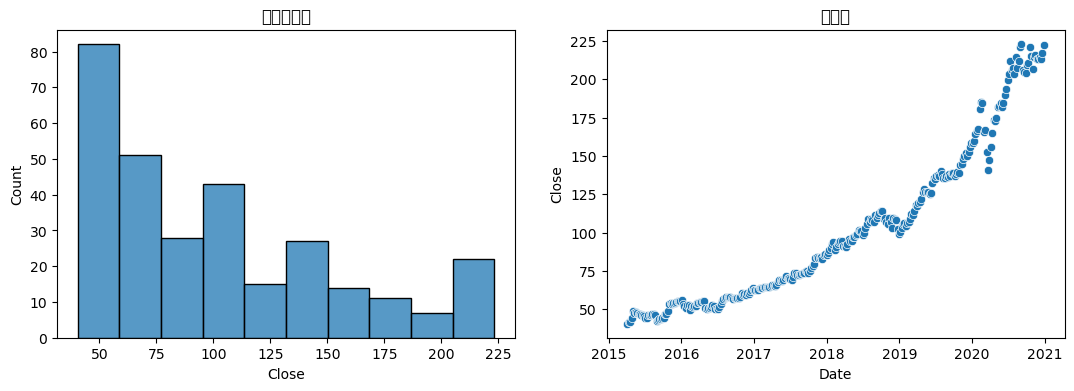


 [요약통계량]
       count    mean    std   min    25%    50%     75%    max
Close  300.0  101.73  51.32  40.5  57.51  90.93  136.58  223.2


In [77]:
# prac 1
ms = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv")
ms['Date'] = ms['Date'].astype('datetime64')
ms = ms.set_index('Date')

down = ms.resample('W').mean()
down_head = down.head(300)
down_tail = down.tail(14)

# prac 2
## EDA
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes[0].set_title("히스토그램")
sns.histplot(x='Close', data=down_head, ax=axes[0])
axes[1].set_title("산점도")
sns.scatterplot(x='Date', y='Close', data=down_head, ax=axes[1])
plt.show()

print("\n [요약통계량]")
print(down_head.describe().round(2).T)

ADF Statistics: 2.240, p-value: 0.999
KPSS Statistics: 2.593, p-value: 0.010


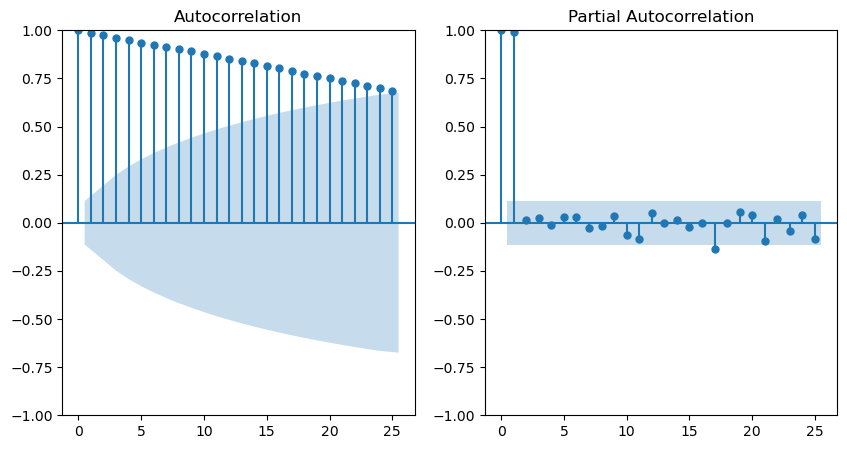

      lb_stat      lb_pvalue
1  294.753777   4.579097e-66
2  582.583051  3.116721e-127
3  863.943057  5.859132e-187
[0.00083511]


In [80]:
## 시계열 EDA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

result = adfuller(down_head, regression='c', autolag='AIC')
print(f"ADF Statistics: {result[0]:.3f}, p-value: {result[1]:.3f}")

result = kpss(down_head, regression='c', nlags='auto')
print(f"KPSS Statistics: {result[0]:.3f}, p-value: {result[1]:.3f}")

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()

result = acorr_ljungbox(down_head, return_df=True, auto_lag=True).head(3)
print(result)

result = durbin_watson(down_head)
print(result)

In [81]:
# prac 3
from pmdarima import auto_arima
auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7,
          seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [82]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 3, 1, 2
P, D, Q, m = 1, 0, 1, 7
model = ARIMA(down_head, order=(p,d,q), seasonal_order=(P,D,Q,m))
fitted = model.fit()
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.515
Date:                           Wed, 10 Jul 2024   AIC                           1557.029
Time:                                   19:17:53   BIC                           1586.633
Sample:                               04-05-2015   HQIC                          1568.878
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1280      0.085      1.509      0.131      -0.038       0.294
ar.L2          0.9914      0.050     19.637

3.49


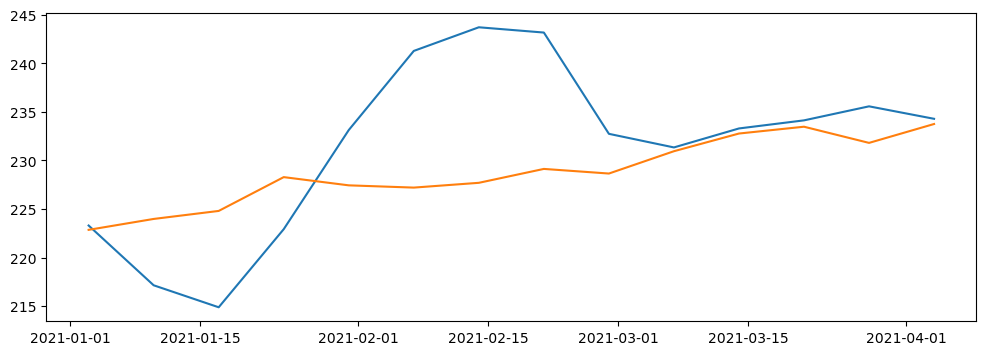

In [85]:
# prac 4
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

pred = fitted.predict(start=down_tail.index[0], end=down_tail.index[-1])
print(MAPE(down_tail.values, pred.values).round(2))

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(down_tail, label='true')
ax.plot(pred, label='pred')
plt.legend
()
plt.show()